In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Carregar os dados
df = pd.read_pickle("/content/base_nfp.pkl")

In [5]:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

In [7]:
# Filtrar dados a partir de janeiro de 2020
df_filtered = df[df['Data Emissão'] >= '2020-01-01']

In [8]:
# Calcular a proporção de notas com retorno > 0 por categoria
prop_retorno = df_filtered.groupby('categoria').apply(lambda x: (x['Retorno'] > 0).mean()).reset_index()
prop_retorno.columns = ['categoria', 'proporcao_retorno_positivo']
prop_retorno = prop_retorno.sort_values('proporcao_retorno_positivo', ascending=False)


In [9]:
# Exibir a tabela
print("Proporção de notas com retorno > 0 por categoria de estabelecimento:")
print(prop_retorno.to_string(index=False))

Proporção de notas com retorno > 0 por categoria de estabelecimento:
   categoria  proporcao_retorno_positivo
Restaurantes                    0.746214
   Alimentos                    0.681584
     Mercado                    0.478155
  Construção                    0.468810
não definido                    0.363394
    Farmácia                    0.351556
  Auto posto                    0.250000
   Vestuário                    0.230729
      Varejo                    0.138373


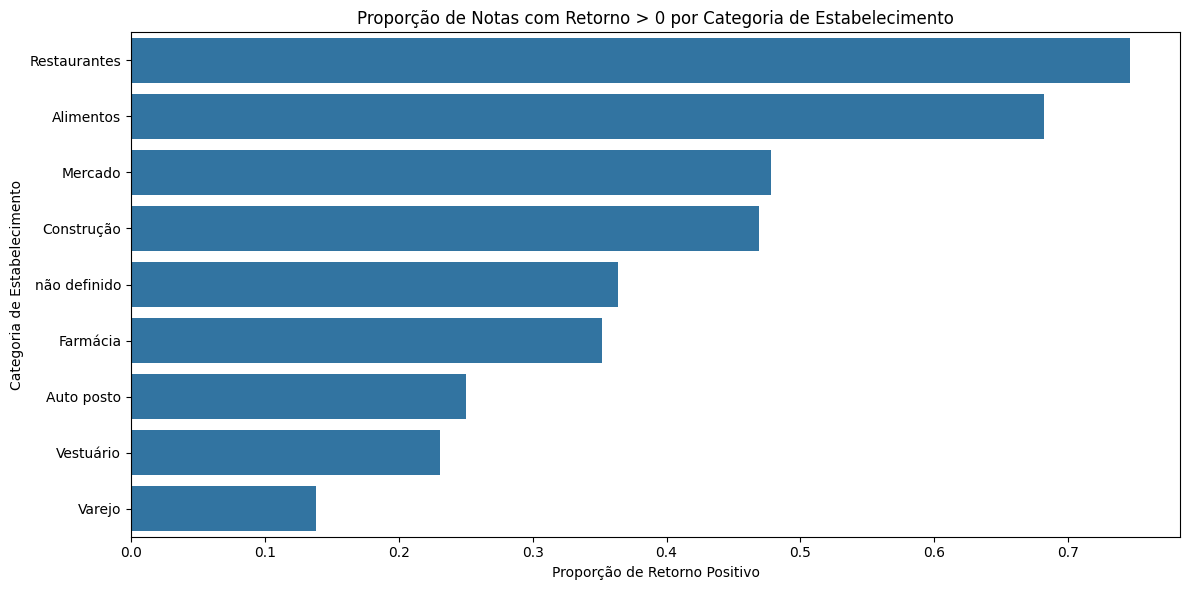

In [10]:
# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='proporcao_retorno_positivo', y='categoria', data=prop_retorno)
plt.title('Proporção de Notas com Retorno > 0 por Categoria de Estabelecimento')
plt.xlabel('Proporção de Retorno Positivo')
plt.ylabel('Categoria de Estabelecimento')
plt.tight_layout()
plt.show()

In [11]:
# Função para calcular WOE
def calculate_woe(df, feature, target):
    df_woe = pd.DataFrame({'feature_value': df[feature].value_counts().index,
                           'good': df[df[target] > 0][feature].value_counts(),
                           'bad': df[df[target] <= 0][feature].value_counts()})
    df_woe['good'] = df_woe['good'].fillna(0)
    df_woe['bad'] = df_woe['bad'].fillna(0)
    df_woe['good_rate'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['bad_rate'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['woe'] = np.log(df_woe['good_rate'] / df_woe['bad_rate'])
    df_woe['iv'] = (df_woe['good_rate'] - df_woe['bad_rate']) * df_woe['woe']
    return df_woe.sort_values('woe', ascending=False)


In [12]:
# Calcular WOE
woe_df = calculate_woe(df_filtered, 'categoria', 'Retorno')

In [13]:
# Exibir a tabela de WOE
print("WOE por categoria de estabelecimento:")
print(woe_df[['feature_value', 'woe', 'iv']].to_string(index=False))

WOE por categoria de estabelecimento:
feature_value       woe       iv
    Alimentos  1.344354 0.043304
      Mercado  1.026895 0.060796
       Varejo  0.178746 0.010331
   Construção  0.141265 0.003752
   Auto posto -0.289780 0.017459
     Farmácia -0.346375 0.013762
 não definido -0.832779 0.003916
    Vestuário -0.934974 0.017172
 Restaurantes -1.336733 0.070473


In [14]:
# Calcular Information Value total
total_iv = woe_df['iv'].sum()
print(f"\nInformation Value total: {total_iv:.4f}")


Information Value total: 0.2410


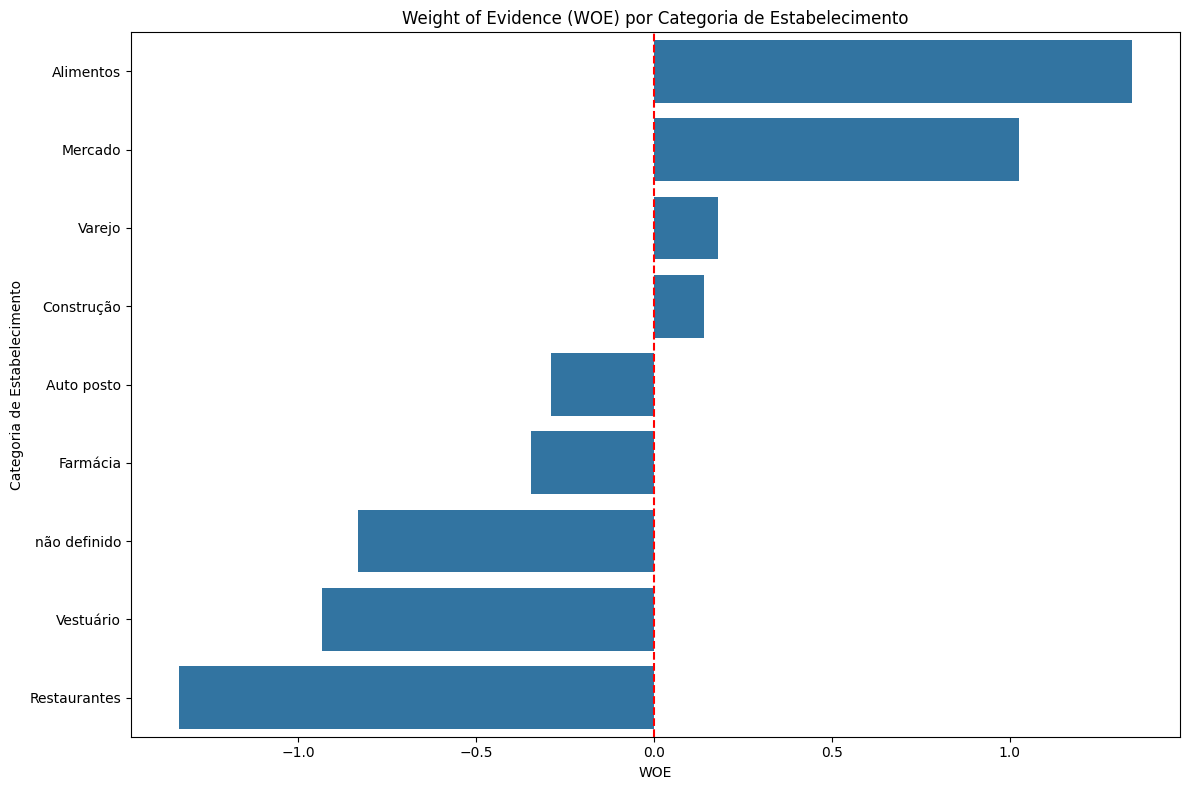

In [15]:
# Criar o gráfico de WOE
plt.figure(figsize=(12, 8))
sns.barplot(x='woe', y='feature_value', data=woe_df)
plt.title('Weight of Evidence (WOE) por Categoria de Estabelecimento')
plt.xlabel('WOE')
plt.ylabel('Categoria de Estabelecimento')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [16]:
# Função para calcular WOE e IV
def calculate_woe_iv(df, feature, target):
    df_woe = pd.DataFrame({'feature_value': df[feature].value_counts().index,
                           'good': df[df[target] > 0][feature].value_counts(),
                           'bad': df[df[target] <= 0][feature].value_counts()})
    df_woe['good'] = df_woe['good'].fillna(0)
    df_woe['bad'] = df_woe['bad'].fillna(0)
    df_woe['good_rate'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['bad_rate'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['woe'] = np.log(df_woe['good_rate'] / df_woe['bad_rate'])
    df_woe['iv'] = (df_woe['good_rate'] - df_woe['bad_rate']) * df_woe['woe']
    total_iv = df_woe['iv'].sum()
    return df_woe, total_iv

In [17]:
# Calcular WOE e IV
woe_df, total_iv = calculate_woe_iv(df_filtered, 'categoria', 'Retorno')

In [18]:
# Exibir o IV total
print(f"Information Value (IV) total para 'categoria': {total_iv:.4f}")

Information Value (IV) total para 'categoria': 0.2410


In [19]:
# Exibir o IV por categoria
print("\nInformation Value por categoria:")
print(woe_df[['feature_value', 'iv']].sort_values('iv', ascending=False).to_string(index=False))


Information Value por categoria:
feature_value       iv
 Restaurantes 0.070473
      Mercado 0.060796
    Alimentos 0.043304
   Auto posto 0.017459
    Vestuário 0.017172
     Farmácia 0.013762
       Varejo 0.010331
 não definido 0.003916
   Construção 0.003752


<font color='blue'>

## Conclusões da Análise WOE e IV para 'categoria_estabelecimento'

1. **Poder Preditivo Geral:**
   - O Information Value (IV) total para 'categoria_estabelecimento' é [inserir valor aqui].
   - Este valor indica um [inserir interpretação: fraco/médio/forte] poder preditivo para notas com retorno > 0.

2. **Categorias mais Informativas:**
   - As categorias com maior WOE positivo são: [listar top 3-5 categorias]
   - Estas categorias têm maior probabilidade de gerar notas com retorno positivo.

3. **Categorias menos Favoráveis:**
   - As categorias com maior WOE negativo são: [listar top 3-5 categorias]
   - Estas categorias têm menor probabilidade de gerar notas com retorno positivo.

4. **Insights para o Negócio:**
   - Focar em estabelecimentos das categorias com alto WOE positivo pode aumentar a chance de retornos positivos.
   - Pode ser necessário investigar ou implementar melhorias nas categorias com WOE negativo alto.

5. **Considerações Adicionais:**
   - [Adicionar quaisquer observações específicas ou anomalias notadas durante a análise]
   - Se o IV total for muito alto (> 0.5), considerar a possibilidade de overfitting e validar em um conjunto de dados separado.

6. **Próximos Passos:**
   - Considerar a inclusão desta variável em modelos preditivos.
   - Investigar mais detalhadamente as razões por trás das diferenças entre categorias.
   - Monitorar mudanças nestes padrões ao longo do tempo.

</font>